In [2]:
import numpy as np


def uniform_length(str, max_len=1000):
    ls = list(eval(str))
    if len(ls) < max_len:
        to_append = [0]*(max_len - len(ls))
        ls += to_append
    ls = ls[:max_len]
    return repr(ls)

def add_feature(srs, split, features):
    for feature in srs.index:
        str = srs[feature]
        ls = list(eval(str))
        if feature in features[split].keys():
            features[split][feature] += [ls]
        else:
            features[split][feature] = [ls]
        
    return features

def get_audio_features(df):
    #rename_split = {'train_wav': 'train', 'dev_wav': 'val', 'test_wav': 'test'}
    #df['split'] = df['split'].map(lambda x: rename_split[x])
    
    ignore = ['filename', 'id', 'conversation_line', 'emotion', 'speaker', 'split']
    audio_features = df.drop(columns=ignore)
    
    same_len_audio_features = audio_features.map(lambda x: uniform_length(x))
    
    features = {'train':{}, 'val':{}, 'test':{}}

    for i in range(len(same_len_audio_features.index)):
        srs = same_len_audio_features.iloc[i]
        split = df['split'].iloc[i]
        features = add_feature(srs, split, features)

    X_train = np.array(list(features['train'].values()))
    X_val = np.array(list(features['val'].values()))
    X_test = np.array(list(features['test'].values()))

    print(X_train.shape)
    
    return np.transpose(X_train, (1, 0, 2)), np.transpose(X_val, (1, 0, 2)), np.transpose(X_test, (1, 0, 2))

In [19]:
import tensorflow as tf

def build_audio_only_model(sequence_length=1000, num_features=18):
    input_layer = tf.keras.layers.Input(shape=(sequence_length, num_features))
    #lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(input_layer)
    lstm_1 = tf.keras.layers.LSTM(128)(input_layer)
    dropout = tf.keras.layers.Dropout(0.3)(lstm_1)
  
    #x = tf.keras.laters.Dense(512, activation='relu')(lstm_1)
    x = tf.keras.layers.Dense(256, activation='relu')(dropout)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.Model(input_layer, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

def build_model(type):
    if type == 'AUDIO-ONLY':
        return build_audio_only_model()
    return None

In [4]:
model_type = 'AUDIO-ONLY'
processed_data_dir = '/Users/teodorastereciu/Documents/bachelors-project/mc-ecpe/data/processed'

In [5]:
def encode_labels(text_labels):
    """ One-hot encodes emotion labels. """

    labels = ['neutral', 'joy', 'surprise', 'anger', 'fear', 'disgust', 'sadness']
    num_classes = len(labels)
    label_to_index = {label: index for index, label in enumerate(labels)}
    index_to_label = {index: label for index, label in enumerate(labels)}

    idx_labels = [label_to_index[label] for label in text_labels]
    onehot_labels = tf.one_hot(idx_labels, len(labels)).numpy()
    return onehot_labels

def get_labels(df):
    train_labels = df[df['split'] == 'train']['emotion']
    val_labels = df[df['split'] == 'val']['emotion']
    test_labels = df[df['split'] == 'test']['emotion']
    return encode_labels(train_labels), encode_labels(val_labels), encode_labels(test_labels)

In [6]:
import matplotlib.pyplot as plt

def plot_history(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true_int, y_pred):
    labels = ['neutral', 'joy', 'surprise', 'anger', 'fear', 'disgust', 'sadness']
    cm_val = confusion_matrix(y_true_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt



def plot_precision_recall(y_true, y_pred):

    labels = ['neutral', 'joy', 'surprise', 'anger', 'fear', 'disgust', 'sadness']
    num_classes = len(labels)
    label_to_index = {label: index for index, label in enumerate(labels)}
    index_to_label = {index: label for index, label in enumerate(labels)}

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label='Class {}: AP={:.2f}'.format(index_to_label[i], average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [9]:
from pathlib import Path
import pandas as pd

model = build_model(model_type)
fname = Path(processed_data_dir) / 'processed_data.csv'

df = pd.read_csv(fname, dtype={'id':str})
rename_split = {'train_wav': 'train', 'dev_wav': 'val', 'test_wav': 'test'}
df['split'] = df['split'].map(lambda x: rename_split[x])
    
#X_train_text, X_val_text, X_test_text = get_text_features(df)
X_train_audio, X_val_audio, X_test_audio = get_audio_features(df)
y_train, y_val, y_test = get_labels(df)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 18)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        42,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,319 (427.03 KB)

 Trainable params: 109,319 (427.03 KB)

 Non-trainable params: 0 (0.00 B)

None
(18, 9966, 1000)


In [10]:
print(X_train_audio.shape)

(9966, 18, 1000)


In [13]:
X_train_reshaped = np.transpose(X_train_audio, (0, 2, 1))
X_val_reshaped = np.transpose(X_val_audio, (0, 2, 1))
print(X_train_reshaped.shape)

(9966, 1000, 18)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1000, 18)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,087 (555.03 KB)

 Trainable params: 142,087 (555.03 KB)

 Non-trainable params: 0 (0.00 B)

None


/Users/teodorastereciu/Documents/bachelors-project/mc-ecpe/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.4461 - loss: 1.6838 - val_accuracy: 0.3855 - val_loss: 1.6925
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.4278 - loss: 1.6102 - val_accuracy: 0.3855 - val_loss: 1.7178
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.4468 - loss: 1.5883 - val_accuracy: 0.3855 - val_loss: 1.6963
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.4388 - loss: 1.5897 - val_accuracy: 0.3790 - val_loss: 1.6943
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.4391 - loss: 1.5994 - val_accuracy: 0.3855 - val_loss: 1.6935


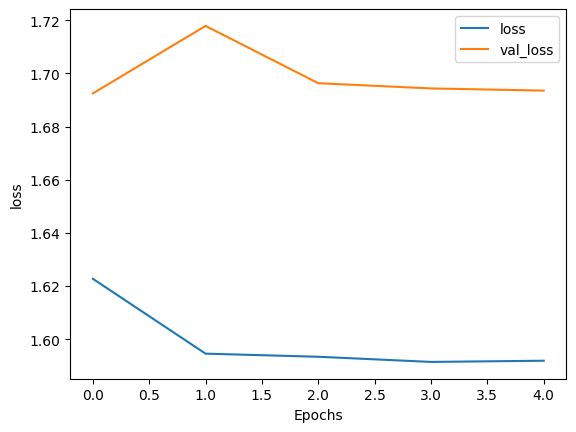

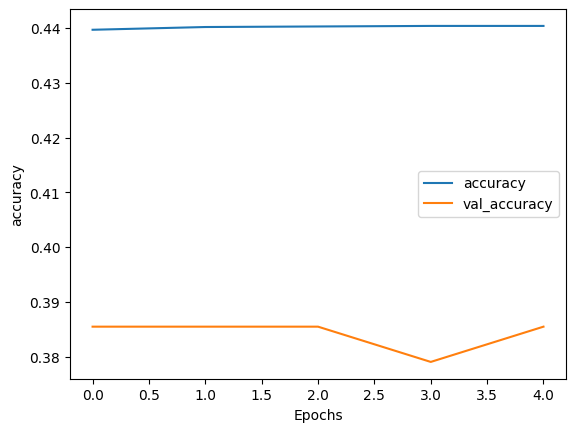

In [20]:
tf.config.run_functions_eagerly(True)
model = build_model(model_type)
history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=5, batch_size=64)

plot_history(history, 'loss')
plot_history(history, 'accuracy')